### Background
#### Customer segmentation - 
It is the process of splitting a customer base into groups according to its similarity.

This concept of similarity depends on common characteristics — such as demographics (e.g., age, gender, income levels) or transactional behaviours (e.g., spending amount, quantity of purchases, days since last purchase) [1].

If we successfully identify the similarities and differences between the groups then we could build targeted strategies for each of them.

Some benefits of customer segmentation are [2]:

More customer retention
Enhances competitiveness
Leads to price optimization
Now, there are several methods to segment customers, but there is one that is fairly common among digital marketers and it’s called RFM Analysis.

#### RFM Analysis -
It is a basic customer segmentation algorithm used to identify a company’s best customers by measuring and analyzing spending habits [3].

This model is based on three main variables:

- Recency: How recently a customer made a purchase (i.e., if you bought something on June 3th and today is June 10th, your recency is 7 days).
- Frequency: How often customers make a purchase (i.e., if you made 5 purchases during a specific time interval of analysis, your frequency is 5).
- Monetary: How much money a customer spends on purchases (i.e., if you buy 3 products priced at $5, then your monetary value is $15).
These variables are relevant indicators of customer’s behaviour because frequency and monetary value affects the customer’s lifetime value, and recency affects retention (a measure of engagement) [4].

However, we don’t want to use just RFM Analysis on this approach, so we introduce a popular Unsupervised Machine Learning algorithm called KMeans.

#### KMeans - 
It is a clustering algorithm which divides a dataset into k clusters, where k is defined a priori. Each cluster refers to a collection of data (in this case users) aggregated together because of certain similarities [5].

In short, we’ll group similar observations together (in k clusters) and discover underlying patterns.

### Business Scenario
In the following analysis, we’ll use a transactional dataset which was randomly generated. The goal is to identify at least 3 transactional-based customer’s clusters using variables such as date, order id, user id and order value.

### About Dataset
The data used in this article is an e-commerce dataset available at Kaggle. The dataset is transactional data that contains the transactions during 2011 for a UK-based retailer.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
raw_data = pd.read_csv('E:\Customer Segmentation using RFM Analysis with KMeans\data.csv', encoding= 'unicode_escape')
raw_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Data Cleaning

In [3]:
# check NA/NULL
raw_data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
# remove NULL
raw_data = raw_data.dropna(axis = 0, how = 'any')

In [5]:
# check duplicates
raw_data.duplicated().sum()

5225

In [6]:
# remove duplicates
raw_data = raw_data.drop_duplicates(ignore_index = True)

### Feature engineering

This step is crucial as we start to transform our raw data to the data with the appropriate format for the upcoming clustering algorithm to consume. To this end, we will do the followings:

- Convert InvoiceDate column to the convenient datetime format
- Create trx_amount column by multiplying Quantity and Unitprice
- Convert CustomerID column to integer format

In [7]:
# convert datetime column format
raw_data.InvoiceDate = pd.to_datetime(raw_data.InvoiceDate)

In [8]:
# create trx_amount col
raw_data['TrxAmount'] = raw_data.Quantity * raw_data.UnitPrice

# include only positive TrxAmount column (exclude credit)
raw_data = raw_data[raw_data['TrxAmount'] > 0]

In [9]:
# cast CustomerID col to interger
raw_data.CustomerID = raw_data.CustomerID.astype('int') 

- With the latest raw_data dataframe format we got from the above code snippet, we are ready to construct a new dataframe for RFM segmentation. The dataframe’s key is CustomerID, with three columns as features: recency, frequency, and monetary.

- First, we address the first feature: recency, which I believe is the most complicated of the three, in terms of preprocessing needed. We’ll start with the code below.

In [10]:
# recency (r) df
data_r = raw_data[['InvoiceDate','CustomerID']].groupby('CustomerID')['InvoiceDate'].agg('max').reset_index()
data_r.head()

,CustomerID,InvoiceDate
0,12346,2011-01-18 10:01:00
1,12347,2011-12-07 15:52:00
2,12348,2011-09-25 13:13:00
3,12349,2011-11-21 09:51:00
4,12350,2011-02-02 16:01:00


- We define user recency as how long it has been (in months) since the user made his last transaction. In this regard, we first need to determine the current time reference that we use for counting the months backward: we set it as the most recent value of InvoiceData column.
- Next, since we consider a customer to be absolutely churned if his or her most recent transaction occurred 6 months ago or more, we have little interest in encoding the recency value if it is greater than 6 months — no longer have meaningful additional information. In other words, the recency values must be clipped to a maximum of 6 months.

In [11]:
# current time benchmark
cur_time = data_r.InvoiceDate.max()

# month diff function
def month_diff(cur_time, datetime_val): 
    return 12 * (cur_time.year - datetime_val.year) + (cur_time.month - datetime_val.month)

# recency month
data_r['Recency'] = data_r.InvoiceDate.apply(lambda datetime_val: month_diff(cur_time, datetime_val))

# clip max at 6 month
data_r.Recency = data_r.Recency.clip(lower = None, upper = 6)

# drop InvoiceDate col
data_r = data_r.drop('InvoiceDate', axis = 1)

# head
data_r.head()

,CustomerID,Recency
0,12346,6
1,12347,0
2,12348,3
3,12349,1
4,12350,6


- We‘re done with recency. Now we’ll create frequency and monetary features. Because we only want the most meaningful (non-obsolete) information, we’ll only consider transactions from the last 6 months when constructing the frequency and monetary features:
- Frequency: the number of transactions completed by the user in the previous six months.
- Monetary: the user’s average transaction size for the last six months
- It is worth noting that this time period constraint is also advantageous in terms of computational standpoint. Assume you are working at Amazon to create the RFM segmentation. If you don’t limit the time window, you’ll end up using their more than two decades of transaction log data (which is supposedly too massive in size).

In [12]:
# frequency & monetary(fm) df only w.r.t. last 6 month data
EARLIEST_DATE = pd.to_datetime('2011-06-09')
data_fm = raw_data[raw_data.InvoiceDate >= EARLIEST_DATE]
data_fm = data_fm[['InvoiceNo','CustomerID','TrxAmount']]

data_fm = data_fm.groupby('CustomerID')[['InvoiceNo','TrxAmount']].agg({'InvoiceNo':'nunique', 'TrxAmount':'mean'}).reset_index()
data_fm = data_fm.rename(columns = {'InvoiceNo':'Frequency', 'TrxAmount':'Monetary'})
data_fm.Monetary = data_fm.Monetary.round(2)
data_fm.head()

,CustomerID,Frequency,Monetary
0,12347,4,25.37
1,12348,1,103.33
2,12349,1,24.08
3,12352,3,20.09
4,12356,1,29.17


- Finally, we join recency dataframe (data_r) with frequency & monetary dataframe (data_fm) to get our final data!

In [13]:
# join to have the final data df
data = data_r.merge(data_fm, on = 'CustomerID', how = 'left')
data = data.fillna(0)
data.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,6,0.0,0.00
1,12347,0,4.0,25.37
2,12348,3,1.0,103.33
3,12349,1,1.0,24.08
4,12350,6,0.0,0.00


In [14]:
# data df shape
data.shape

(4338, 4)

### RFM Segmentation via K-means Clustering
#### Standardize columns
It is best practice to standardize the R-F-M features, particularly since the monetary function has the measure of money, implying that the scales are substantially different from the other features. By standardizing it, we ensure that the K-means algorithm does not overvalue this monetary function (i.e., considering it as a more important feature than the other features).

In [15]:
from sklearn.preprocessing import StandardScaler
# feature columns
feature_cols = ['Recency','Frequency','Monetary']
# standardized df for training
standardized_data = data.copy()
# standardization
scaler = StandardScaler()
scaler.fit(data[feature_cols])
standardized_features = scaler.transform(data[feature_cols])
standardized_data[feature_cols] = standardized_features

### Elbow method to Determine the Optimal K

K (the number of clusters) in the K-means algorithm is, as you might know, a hyperparameter. As a result, we must choose it carefully ahead of time. The Elbow method is a common way to choose K optimally: we plot the sum of squared errors (SSE) for various K values and choose the K value at which the SSE decline slopes change significantly between before and after the value.

For those that are unfamiliar with SSE, the term “error” refers to the deviation/distance between a data point and its centroid. SSE is thus the number of such squared errors for all data points. It’s also worth noting that SSE values always decrease as K increases.

To proceed, we fit K-means algorithm ten times with ten different Ks (1,2,…,10) and save the SSE of each converged model (notice that the SSE is stored in theinertia_ attribute).

In [16]:
# fit K-means clustering on various Ks
from sklearn.cluster import KMeans
kmeans_kwargs = {
    "init" : "random",
    "n_init" : 10
}
sse = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(standardized_data[feature_cols])
    sse.append(kmeans.inertia_)

#### Let us visualize the Elbow method!

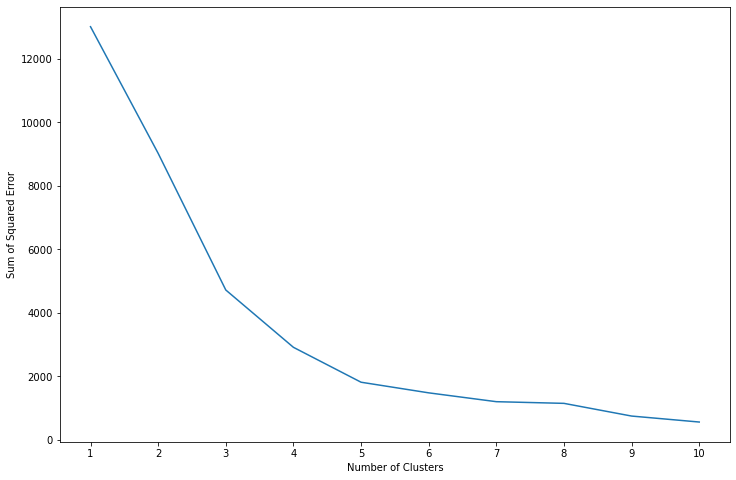

In [17]:
# Elbow method plot
import matplotlib.pyplot as plt
plt.figure(figsize = (12,8))
plt.plot(range(1,11), sse)
plt.xticks(range(1,11))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Error")
plt.show()

- Looking at the plot above, it is clear that we can select K= 3: observe the large difference in slopes before and after this particular value of K.

#### Fit K-means using the optimal K

After knowing the optimal K is 3, we fit the algorithm once again using this K value.

In [18]:
kmeans_kwargs = {
    "init" : "random",
    "n_init" : 10
}
# run kmeans with the optimal k
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(standardized_data[feature_cols])
data['cluster'] = kmeans.labels_
data.head()

,CustomerID,Recency,Frequency,Monetary,cluster
0,12346,6,0.0,0.00,0
1,12347,0,4.0,25.37,2
2,12348,3,1.0,103.33,2
3,12349,1,1.0,24.08,2
4,12350,6,0.0,0.00,0


### Results Analysis
Our work is not yet over. We must interpret the clusters after they have been collected. To that end, we can summarize the obtained clusters by displaying their R-F-M centroid values as well as the number of users in each cluster.

Why centroid values? Because we may consider the values to be the representative of each obtained cluster. As a result, we can use these values to interpret the overall behavior/characteristics of users that belong to a specific cluster in terms of the corresponding user aspect (R/F/M).

In [19]:
# look at the centroids per cluster
centroid_df = data.groupby('cluster')[['Recency', 'Frequency', 'Monetary','CustomerID']].agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary':'mean','CustomerID':'nunique'}).reset_index()
centroid_df = centroid_df.rename(columns = {'CustomerID':'NumBuyers'})
centroid_df

,cluster,Recency,Frequency,Monetary,NumBuyers
0,0,5.555718,0.493402,24.198798,1364
1,1,0.000000,1.000000,168469.600000,1
2,2,1.291625,3.381433,32.123858,2973


### According to the table above, we have three user clusters/segments:

#### Cluster 2: 
Our top segment of users. Users in this category are recent/current regular buyers (recency low, frequency high). Their most recent transaction was only a few days ago, with a frequency of 26 transactions in the previous six months. Unfortunately, there are just a handful of them (66 users, equivalent to 1.5 percent of all user base).

#### Cluster 0: 
Our churned segment of users. Users in this category are our opt-out customers (recency high [note this is a bad thing], frequency low). Their last transaction was more than five months ago, with just 0 or 1 transaction in the previous six months! They are also, unfortunately, many (1364 users, equivalent to 31.5 percent of all user base).

#### Cluster 1: 
Our casual segment of users. Users in this category are our regular customers (modest on both recency and frequency). Their most recent transaction was within the last two months, with a frequency of up to three transactions in the previous six months. They are, as is widely observed, the largest portion of our user base (2908 users, equivalent to 67 percent of all user base)

In [20]:
# give high-level name for each cluster
centroid_df.pop('cluster')

cluster_names = ['Casul Buyers','Churned Buyers','Top Buyers']
centroid_df['ClusterName'] = cluster_names

centroid_df

,Recency,Frequency,Monetary,NumBuyers,ClusterName
0,5.555718,0.493402,24.198798,1364,Casul Buyers
1,0.000000,1.000000,168469.600000,1,Churned Buyers
2,1.291625,3.381433,32.123858,2973,Top Buyers


### Actionable steps

We will create a customized promotion strategy for each cluster based on the understanding of the above clusters, as follows:

#### Top buyers: 
There is no need to overwhelm them with vouchers/promotions (this saves us money), but we can optimize/leverage some kind of loyalty points to keep them around.

#### Casual buyers: 
We need to increase the frequency and monetary value of this segment. We can accomplish this by providing vouchers in the form of cashback (to enable repeat purchases), with a high eligibility threshold (e.g., the voucher is only valid for transaction amount at least 50 Pounds).

#### Churned buyers: 
Our top priority is to get them transacting with us again after they’ve been churned for a while. To encourage them to do so, we could offer one or two large-benefit vouchers. This goes hand in hand with a steady stream of push notifications.